In [1]:
from tqdm import tqdm
import pandas as pd
import jsonlines
import numpy as np
import math
from sklearn.linear_model import LogisticRegression
import plotly.express as px
# from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
# from scipy import stats
import os


## General Functions to Read Documents

In [3]:
import jsonlines
def read_jsonl(file):
    results = []
    with jsonlines.open(file) as reader:
        for obj in reader:
            results.append(obj)
    return results

## Check contamination percentage compared to other static baselines

In [86]:
# function to get bing search results
import json
import os 
from pprint import pprint
import requests

# Add your Bing Search V7 subscription key and endpoint to your environment variables.
subscription_key = 'your_key'
endpoint = 'https://api.bing.microsoft.com' + "/v7.0/search"

def search_bing_results(query):
    # Construct a request
    mkt = 'en-US'
    params = { 'q': query, 'mkt': mkt }
    headers = { 'Ocp-Apim-Subscription-Key': subscription_key }

    # Call the API
    try:
        response = requests.get(endpoint, headers=headers, params=params)
        response.raise_for_status()
        
        results = response.json()
        snippets = []
        for r in results['webPages']['value']:
            snippets.append(r['name'] + ' '+ r['snippet'])
        return response, snippets
    except Exception as ex:
        # raise ex
        print('encountered exception', ex)
        return None, None

In [87]:
from tqdm import tqdm
import numpy as np
# collect all unique strings of size string_size
def build_substrings(data, string_size, text_processing_method=None):
    set_strings = {}
    # for i in tqdm(range(len(data))):
    for i in range(len(data)):
        text_i = data[i]
        clean_text_i = text_i
        if text_processing_method != None:
            clean_text_i = text_processing_method(text_i)

        if len(clean_text_i) < string_size:
            strings_i = {clean_text_i: 0}
        else:
            strings_i = {}
            for j in range(len(clean_text_i)-string_size):
                string = clean_text_i[j:(j+string_size)]
                strings_i[string] = 0
        for string in strings_i.keys():
            if not(string in set_strings.keys()):
                set_strings[string] = 0
            set_strings[string] += 1

    return set_strings

def clean_text_gpt4(text):
    text = ''.join(i if i.isalpha() else '' for i in text)  # keep alphanumeric characters

    return text

# find strings which have been seen before
def overlap_substrings_sample(
    data,
    strings_set,
    string_size,
    n_samples,
    text_processing_method=None
):
    all_tagged = []
    # for i in tqdm(range(len(data))):
    for i in range(len(data)):
        text_i = data[i]
        clean_text_i = text_i
        if text_processing_method != None:
            clean_text_i = text_processing_method(text_i)

        tagged = 0
        if len(clean_text_i) <= string_size:
            for k in strings_set.keys():
                if k.startswith(clean_text_i):
                    tagged = 1
                    break
        else:
            for _ in range(n_samples):
                start_idx = np.random.randint(0, len(clean_text_i)-string_size, 1)[0]
                string = clean_text_i[start_idx:(start_idx+string_size)]
                if string in strings_set.keys():
                    tagged = 1
                    break
        all_tagged.append(int(tagged > 0))

    return all_tagged

In [84]:
# substring-match: GPT-4 method
def check_contamination_gpt4(eval_data, train_data):
    string_size = 50
    train_substrings = build_substrings(train_data, string_size, clean_text_gpt4)

    n_samples = 3
    contaminated = overlap_substrings_sample(
        eval_data,
        train_substrings,
        string_size,
        n_samples,
        clean_text_gpt4
    )
    print('contaminated:', contaminated)
    frac = 100 * np.mean(contaminated)
    n_contaminated = np.sum(contaminated)
    # print(f"# Contaminated points: {n_contaminated}/{len(contaminated)} or {frac:.4f}%")
    return frac

In [85]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# check contamination: embedding similarity method
def check_contamination_playtus(eval_data, train_data):
    model_name = "all-MiniLM-L6-v2"
    model = SentenceTransformer(model_name)
    eval_embeddings = model.encode(eval_data)
    train_embeddings = model.encode(train_data)

    cos = cosine_similarity(eval_embeddings, train_embeddings)

    thresh = 0.8
    contaminated = (np.max(cos, axis=1) >= thresh).astype(int)
    frac = 100 * np.mean(contaminated)
    
    print('contaminated: ', contaminated)
    return frac

/Users/ruochen/miniconda3/envs/LLM_eval/lib/python3.9/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [54]:
import random
import warnings
warnings.filterwarnings("ignore")
def detect_contamination(questions, sample_size=100):
    random.seed(42)
    # sample without replacement
    questions = random.sample(questions, sample_size)
    contamination_gpt4 = []
    contamination_playtus = []
    search_results_jsons = []
    failed = 0
    for q in tqdm(questions):
        response, search_results = search_bing_results(q)
        search_results_jsons.append(response)
        if response == None:
            failed += 1
        else:
            contamination_gpt4.append(check_contamination_gpt4([q], search_results))
            contamination_playtus.append(check_contamination_playtus([q], search_results))
            break
    print('mean contamination gpt4:', np.mean(contamination_gpt4))
    print('mean contamination playtus:', np.mean(contamination_playtus))
    if failed > 0:
        print(f'Failed to get search results for {failed} questions')
    return search_results_jsons

In [35]:
generated_questions = read_jsonl('../data/generated_questions_difficult.jsonl')
generated_questions = [q['question'] for q in generated_questions]

generated_q_jsons = detect_contamination(generated_questions, sample_size=100)

  0%|          | 0/100 [00:00<?, ?it/s]/Users/ruochen/miniconda3/envs/LLM_eval/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
  1%|          | 1/100 [00:06<11:19,  6.86s/it]/Users/ruochen/miniconda3/envs/LLM_eval/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
  2%|▏         | 2/100 [00:10<08:16,  5.06s/it]/Users/ruochen/miniconda3/envs/

Our generated questions:
mean contamination gpt4: 2.0
mean contamination playtus: 28.0


In [55]:
from datasets import load_dataset

print('MMLU contamination:')
mmlu_questions = load_dataset("lighteval/mmlu", "all")['test']['question']
mmlu_jsons = detect_contamination(mmlu_questions, sample_size=100)

MMLU contamination:


 15%|█▌        | 15/100 [00:59<04:08,  2.92s/it]

encountered exception 'webPages'


 76%|███████▌  | 76/100 [05:17<01:21,  3.39s/it]

encountered exception 'webPages'


100%|██████████| 100/100 [06:57<00:00,  4.17s/it]

Our generated questions:
mean contamination gpt4: 41.83673469387755
mean contamination playtus: 40.816326530612244
Failed to get search results for 2 questions


In [59]:
print('ARC Challenge contamination:')
arcc_questions = load_dataset("allenai/ai2_arc", "ARC-Challenge")['test']['question']
arcc_jsons = detect_contamination(arcc_questions, sample_size=100)


ARC Challenge contamination:


100%|██████████| 100/100 [07:23<00:00,  4.43s/it]

Our generated questions:
mean contamination gpt4: 33.0
mean contamination playtus: 35.0


In [61]:
print('Hellaswag contamination:')
hellaswag_questions = load_dataset("Rowan/hellaswag")['test']['ctx']
hellaswag_jsons = detect_contamination(hellaswag_questions, sample_size=100)

Hellaswag contamination:


100%|██████████| 100/100 [08:22<00:00,  5.03s/it]

Our generated questions:
mean contamination gpt4: 18.0
mean contamination playtus: 43.0


#### Ablation study results with statistical testing

In [53]:
gpt4_results = read_jsonl('../data/ablation_self_enhancement_bias/judge_gpt4_questions.jsonl')[:30]
haiku_results = read_jsonl('../data/ablation_self_enhancement_bias/judge_haiku_questions.jsonl')[:30]

In [54]:
from collections import defaultdict
import numpy as np

def index(t):
    if t == 'gpt-4-turbo-2024-04-09':
        return 0
    elif t == 'claude-3-haiku-20240307':
        return 1
    elif t == 'tie':
        return 2

def calculate_win_rate(results):
    # count wins
    wins = []
    for r in results:
        final_winner = r['final_winner'][-1]
        model_a = r['gamekey'][1]
        model_b = r['gamekey'][2]
        # overall win rate
        if final_winner == 'A':
            wins.append(index(model_a))
        elif final_winner == 'B':
            wins.append(index(model_b))
        # elif final_winner == 'tie':
        #     wins.append(index('tie'))
    print('GPT-4 win rates: ', np.mean([w == 0 for w in wins]))
    print('Haiku win rates: ', np.mean([w == 1 for w in wins]))
    # print('Tie rates: ', np.mean([w == 2 for w in wins]))
    return wins
    
print('GPT4 questions:')
gpt4_winners = calculate_win_rate(gpt4_results)
print('Claude3 questions')
haiku_winners = calculate_win_rate(haiku_results)

GPT4 questions:
GPT-4 win rates:  0.8
Haiku win rates:  0.2
Claude3 questions
GPT-4 win rates:  0.7692307692307693
Haiku win rates:  0.23076923076923078


In [55]:
print('Kolmogorov-Smirnov test for goodness of fit:')
# Kolmogorov-Smirnov test for goodness of fit.
# Null hypothesis: the distribution of the two samples is the same.
# A small p-value indicates that the two samples are significantly different.

from scipy import stats
print(stats.kstest(gpt4_winners, haiku_winners))

print('\nFisher Exact Test:')
# Fisher's Exact Test
# Null hypothesis: the two samples are independent
# A small p-value indicates that the two samples are significantly dependent

from scipy.stats import fisher_exact
fisher_exact([[np.sum([w == 0 for w in gpt4_winners]), np.sum([w == 0 for w in haiku_winners])],
              [np.sum([w == 1 for w in gpt4_winners]), np.sum([w == 1 for w in haiku_winners])]])

Kolmogorov-Smirnov test for goodness of fit:
KstestResult(statistic=0.03076923076923077, pvalue=1.0, statistic_location=0, statistic_sign=1)

Fisher Exact Test:


SignificanceResult(statistic=1.2, pvalue=1.0)

In [58]:
real_results = read_jsonl('data/ablation_self_enhancement_bias/judge_real_questions.jsonl')[:len(gpt4_results)]
# gpt4_results = read_jsonl('data/ablation_self_enhancement_bias/judge_gpt4_questions.jsonl')
# gpt4_results = haiku_results
# gpt4_results = gpt4_results[:len(real_results)]

print('GPT4 questions:')
gpt4_winners = calculate_win_rate(gpt4_results)
print('Real questions')
real_winners = calculate_win_rate(real_results)

GPT4 questions:
GPT-4 win rates:  0.8
Haiku win rates:  0.2
Real questions
GPT-4 win rates:  0.7586206896551724
Haiku win rates:  0.2413793103448276


In [59]:
print('Kolmogorov-Smirnov test for goodness of fit:')
# Kolmogorov-Smirnov test for goodness of fit.
# Null hypothesis: the distribution of the two samples is the same.
# A small p-value indicates that the two samples are significantly different.

from scipy import stats
print(stats.kstest(gpt4_winners, real_winners))

print('\nFisher Exact Test:')
# Fisher's Exact Test
# Null hypothesis: the two samples are independent
# A small p-value indicates that the two samples are significantly dependent

from scipy.stats import fisher_exact
print(fisher_exact([[np.sum([w == 0 for w in gpt4_winners]), np.sum([w == 0 for w in real_winners])],
                    [np.sum([w == 1 for w in gpt4_winners]), np.sum([w == 1 for w in real_winners])]]))



Kolmogorov-Smirnov test for goodness of fit:
KstestResult(statistic=0.041379310344827586, pvalue=0.9999999999999307, statistic_location=0, statistic_sign=1)

Fisher Exact Test:
SignificanceResult(statistic=1.2727272727272727, pvalue=0.7610684967280272)


#### Whether synthetic questions can be told

In [81]:
import pandas as pd

# real questions and synthetic questions
real_questions = read_jsonl('data/ablation_self_enhancement_bias/real_math_questions.jsonl')
real_questions = [q['question'] for q in real_questions]
synthetic_questions = read_jsonl('data/ablation_self_enhancement_bias/gpt4_math_questions_difficult.jsonl')
synthetic_questions = [q['question'] for q in synthetic_questions]

human_results = pd.read_csv('data/ablation_self_enhancement_bias/synthetic.csv')
# remove the 'timestamp' column
human_results = human_results.drop(columns=['Timestamp'])
# get row 0
user_1 = human_results.iloc[0]
user_2 = human_results.iloc[1]

In [8]:
def get_user_results(user_1):
    acc = []
    for k in user_1.keys():
        rating = user_1[k]
        if rating == 3:
            acc.append(-1)
        elif (k in real_questions and rating > 3) or (k in synthetic_questions and rating < 3):
            acc.append(1)
        else:
            acc.append(0)
    print('Correct:', np.sum([a == 1 for a in acc])/len(acc))
    print('Cannot Tell: ', np.sum([a == -1 for a in acc])/len(acc))
    print('Incorrect: ', np.sum([a == 0 for a in acc])/len(acc))
    return acc

In [82]:
print('--------User 1--------')
user_1_results = get_user_results(user_1)

print('--------User 2--------')
user_2_results = get_user_results(user_2)

--------User 1--------
Correct: 0.2711864406779661
Cannot Tell:  0.2711864406779661
Incorrect:  0.4576271186440678
--------User 2--------
Correct: 0.3898305084745763
Cannot Tell:  0.11864406779661017
Incorrect:  0.4915254237288136


In [83]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(user_1_results, user_2_results)

-0.1172227231740306

## ELO Computation

In [9]:
def read_tournament(tournament_dir, read_added = True):
    rounds = [r for r in os.listdir(tournament_dir) if 'round' in r]
    if not read_added:
        rounds = [r for r in rounds if 'add' not in r]

    judge_files = []
    for r in rounds:
        judge_files += [f'{tournament_dir}/{r}/{f}' for f in os.listdir(f'{tournament_dir}/{r}') if f.endswith('_judge_results.jsonl')]
    judge_results = []
    for j in judge_files:
        judge_results.extend(list(read_jsonl(j)))
    print(f'loaded {len(judge_results)} judge results')
    return judge_results

In [5]:
def judge_results_to_df(judge_results, judge_debate_rounds = 1):
    # Show all judgements as a dataframe
    model_a = [j['gamekey'][1] for j in judge_results]
    model_b = [j['gamekey'][2] for j in judge_results]
    winner = [j['final_winner'][judge_debate_rounds] for j in judge_results]
    df = pd.DataFrame({'model_a': model_a, 'model_b': model_b, 'winner': winner})
    df = df[df['winner'] != 'tie']
    return df

In [6]:
# This is the same function as in Chatbot Arena: https://colab.research.google.com/drive/1KdwokPjirkTmpO_P1WByFNFiqxWQquwH
# maxmium likelihood estimation for elo score
def compute_mle_elo(df, SCALE=400, BASE=10, INIT_RATING=1000):
    models = pd.concat([df["model_a"], df["model_b"]]).unique()
    models = pd.Series(np.arange(len(models)), index=models)

    # duplicate battles
    df = pd.concat([df, df], ignore_index=True)
    p = len(models.index)
    n = df.shape[0]

    X = np.zeros([n, p])
    X[np.arange(n), models[df["model_a"]]] = +math.log(BASE)
    X[np.arange(n), models[df["model_b"]]] = -math.log(BASE)

    # one A win => two A win
    Y = np.zeros(n)
    Y[df["winner"] == "A"] = 1.0

    # one tie => one A win + one B win
    # find tie + tie (both bad) index
    tie_idx = (df["winner"] == "tie")
    tie_idx[len(tie_idx)//2:] = False
    Y[tie_idx] = 1.0

    lr = LogisticRegression(fit_intercept=False, penalty=None, tol=1e-8)
    lr.fit(X,Y)

    elo_scores = SCALE * lr.coef_[0] + INIT_RATING

    # set anchor as mixtral = 1000
    if "Mixtral-8x7B-Instruct-v0.1" in models.index:
        elo_scores += 1000 - elo_scores[models["mixtral-8x7b-instruct-v0.1"]]
    return pd.Series(elo_scores, index = models.index).sort_values(ascending=False)

In [7]:
# This is the same function as in Chatbot Arena: https://colab.research.google.com/drive/1KdwokPjirkTmpO_P1WByFNFiqxWQquwH
# print ELO score results
def preety_print_model_ratings(ratings):
    df = pd.DataFrame([
        [n, ratings[n]] for n in ratings.keys()
    ], columns=["Model", "Elo rating"]).sort_values("Elo rating", ascending=False).reset_index(drop=True)
    # df["Elo rating"] = (df["Elo rating"] + 0.5).astype(int)
    df.index = df.index + 1
    return df

In [8]:
judge_results = read_tournament('../data/main_tour_40')
df = judge_results_to_df(judge_results)
# ELOs of all 17 models
elo_mle_ratings = compute_mle_elo(df)
preety_print_model_ratings(elo_mle_ratings)

loaded 1680 judge results


,Model,Elo rating
1,claude-3-5-sonnet-20240620,1214.118132
2,gpt-4o-2024-05-13,1155.895988
3,gpt-4-turbo-2024-04-09,1114.009872
4,command-r-plus,1050.118426
5,meta-llama/Llama-3-70b-chat-hf,1041.215537
6,gemini-1.5-flash-exp-0827,1031.852407
7,claude-3-haiku-20240307,1023.857802
8,google/gemma-2-27b-it,1013.968162
9,Qwen/Qwen2-72B-Instruct,1013.856359
10,Qwen/Qwen1.5-72B-Chat,1011.936426


## Calculation of Agreement Among Judges

In [10]:
# read main tournament results on 9 models

judge_debate_rounds = 1
tournament_dir = '../data/main_tour_40'
rounds = [r for r in os.listdir(tournament_dir) if 'round' in r and 'add' not in r]

judge_files = []
for r in rounds:
    judge_files += [f'{tournament_dir}/{r}/{f}' for f in os.listdir(f'{tournament_dir}/{r}') if f.endswith('_judge_results.jsonl')]

judge_results_main = []
for j in judge_files:
    judge_results_main.extend(list(read_jsonl(j)))
print(f'loaded {len(judge_results_main)} judge results')
judge_results_main = [j for j in judge_results_main if j['judge_debate_rounds'] == judge_debate_rounds]
print(f'filtered to {len(judge_results_main)} judge results')

loaded 640 judge results
filtered to 640 judge results


In [11]:
# probability of two models agreeing (like MT-Bench)
def judge_agreement(judge_results, judge_debate_rounds, judges):
    pairings = [(a, b) for idx, a in enumerate(judges) for b in judges[idx + 1:]]
    agree = 0
    total = 0
    for (a, b) in pairings:
        for eval in judge_results:
            # exclude error
            if a in eval['judges'] and b in eval['judges'] and eval[a]['winner'][judge_debate_rounds] != 'error' and eval[b]['winner'][judge_debate_rounds] != 'error':
                total += 1
                # count ties
                if eval[a]['winner'][judge_debate_rounds] == eval[b]['winner'][judge_debate_rounds]:
                    agree += 1
    print(f"Probability of two judges agreeing: {agree/total}")

In [12]:
judges = ['gpt-4-turbo-2024-04-09', 'Qwen/Qwen1.5-72B-Chat', 'claude-3-haiku-20240307',
            'zero-one-ai/Yi-34B-Chat', 'mistralai/Mixtral-8x7B-Instruct-v0.1', 'gpt-35-turbo-0125',
            'meta-llama/Llama-2-70b-chat-hf', 'command-r-plus', 'deepseek-ai/deepseek-llm-67b-chat']
print('Agreement before discussion:')
judge_agreement(judge_results_main, 0, judges)
print('Agreement after discussion:')
judge_agreement(judge_results_main, 1, judges)

Agreement before discussion:
Probability of two judges agreeing: 0.5346056564727524
Agreement after discussion:
Probability of two judges agreeing: 0.6376432078559738


In [13]:
# Cohen's Kappa agreement (Average)
def calculate_cohen_kappa(j1, j2, judge_results, judge_debate_rounds):
    rater_1 = []
    rater_2 = []
    for eval in judge_results:
        if j1 in eval['judges'] and j2 in eval['judges'] and eval[j1]['winner'][judge_debate_rounds] != 'error' and eval[j2]['winner'][judge_debate_rounds] != 'error':
           rater_1.append(eval[j1]['winner'][judge_debate_rounds])
           rater_2.append(eval[j2]['winner'][judge_debate_rounds])
    # print(f'length of {j1} and {j2}: {len(rater_1)}')
    # if length is less than 100, return 0
    score = cohen_kappa_score(rater_1, rater_2)
    return score

def calculate_tournament_cohens_kappa(judges, judge_results, judge_debate_rounds):
    all_cohen_kappas = []
    already_evaled_pairs = []
    data = np.zeros((len(judges), len(judges)))
    for i_1, j_1 in enumerate(judges):
        for i_2, j_2 in enumerate(judges):
            score = calculate_cohen_kappa(j_1, j_2, judge_results, judge_debate_rounds)
            data[i_1][i_2] = score
            if (j_1, j_2) not in already_evaled_pairs and (j_2, j_1) not in already_evaled_pairs and j_1 != j_2:
                already_evaled_pairs.append((j_1, j_2))
                all_cohen_kappas.append(score)
    print(f"Average Cohen Kappa: {np.mean(all_cohen_kappas)}")
    return data

In [14]:
# only use the top 5 judges
# because the last two doesn't serve in the committee for enough times to calculate stable kappa
judges = ['gpt-4-turbo-2024-04-09', 'command-r-plus', 'claude-3-haiku-20240307',
            'Qwen/Qwen1.5-72B-Chat', 'zero-one-ai/Yi-34B-Chat']
print('Before Discussion: ')
data_before = calculate_tournament_cohens_kappa(judges, judge_results_main, 0)
print('After Discussion: ')
data_after = calculate_tournament_cohens_kappa(judges, judge_results_main, 1)

Before Discussion: 
Average Cohen Kappa: 0.15601078432898247
After Discussion: 
Average Cohen Kappa: 0.2713835403738685


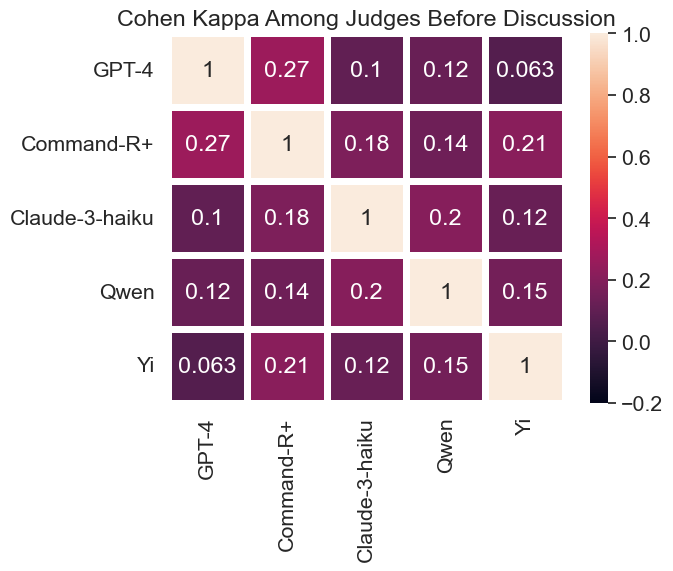

In [133]:
# Plot Cohen's Kappa agreement

judge_names = ['GPT-4', 'Command-R+', 'Claude-3-haiku', 'Qwen','Yi']

sns.heatmap(
    data_before, 
    # mask=np.tri(len(judges)),
    annot=True, linewidths=5,
    vmin=-0.2, vmax=1,
    xticklabels=judge_names,
    yticklabels=judge_names,
)
plt.title('Cohen Kappa Among Judges Before Discussion')
plt.savefig('../assets/agreement_figures/cohen_kappa_among_judges_0.png', bbox_inches="tight")
plt.show()

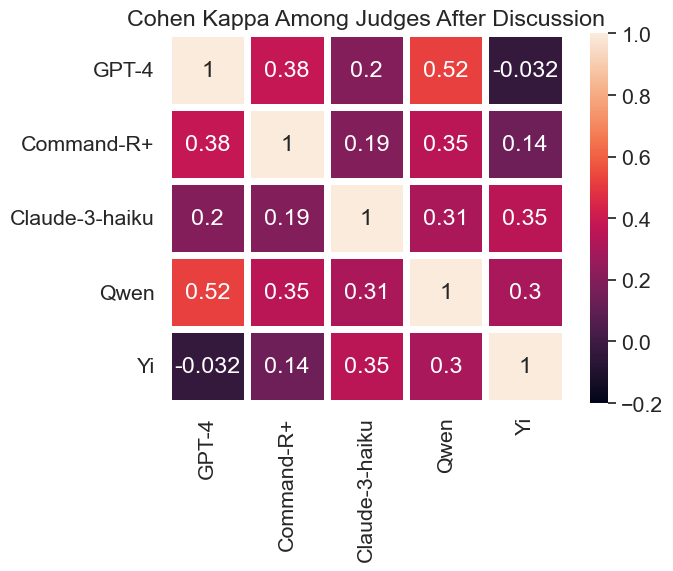

In [134]:
# Plot Cohen's Kappa agreement
sns.heatmap(
    data_after, 
    # mask=np.tri(len(judges)),
    annot=True, linewidths=5,
    vmin=-0.2, vmax=1,
    xticklabels=judge_names,
    yticklabels=judge_names,
)
plt.title('Cohen Kappa Among Judges After Discussion')
plt.savefig('../assets/agreement_figures/cohen_kappa_among_judges.png', bbox_inches="tight")
plt.show()

#### Calculation of agreement between each judge and the majority vote results

In [15]:
def calculate_majority_vote_cohen_kappa(j1, judge_results, judge_debate_rounds):
    rater_1 = []
    majority_vote = []
    for eval in judge_results:
        if j1 in eval['judges'] and eval[j1]['winner'][judge_debate_rounds] != 'error':
           rater_1.append(eval[j1]['winner'][judge_debate_rounds])
           majority_vote.append(eval['final_winner'][judge_debate_rounds])
    return cohen_kappa_score(rater_1, majority_vote)

Average Cohen Kappa: 0.40928445250274476


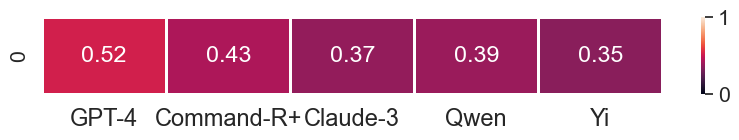

In [16]:
sns.set(font_scale=1.4)
data = np.zeros(len(judges))
for i_1, j_1 in enumerate(judges):
        data[i_1] = calculate_majority_vote_cohen_kappa(j_1, judge_results_main, 0)
print(f"Average Cohen Kappa: {np.mean(data)}")

data = data.reshape(-1, 1).transpose()
# judge_names = ['GPT-4', 'Claude-3', 'Qwen', 'Mixtral','Yi', 'GPT-3.5', 'Llama-2']
judge_names = ['GPT-4', 'Command-R+', 'Claude-3', 'Qwen','Yi']
fig, ax = plt.subplots(figsize=(10,1))  
sns.heatmap(
    data, 
    # mask=np.tri(len(judges)),
    annot=True, linewidths=1,
    vmin=0, vmax=1,
    xticklabels=judge_names,
)
plt.xticks(rotation=0, fontsize = 17) 
# plt.title('Cohen Kappa With Majority Vote Before Discussion')
plt.savefig('../assets/agreement_figures/cohen_kappa_with_majority_vote_0.png', bbox_inches="tight")
plt.show()

Average Cohen Kappa: 0.537248233304654


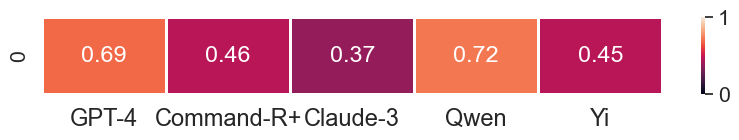

In [17]:
data = np.zeros(len(judges))
for i_1, j_1 in enumerate(judges):
        data[i_1] = calculate_majority_vote_cohen_kappa(j_1, judge_results_main, 1)
print(f"Average Cohen Kappa: {np.mean(data)}")

data = data.reshape(-1, 1).transpose()
# judge_names = ['GPT-4', 'Claude-3', 'Qwen', 'Mixtral','Yi', 'GPT-3.5', 'Llama-2']
judge_names = ['GPT-4', 'Command-R+', 'Claude-3', 'Qwen','Yi']
fig, ax = plt.subplots(figsize=(10,1))  
sns.heatmap(
    data, 
    # mask=np.tri(len(judges)),
    annot=True, linewidths=1,
    vmin=0, vmax=1,
    xticklabels=judge_names,
)
# plt.title('Cohen Kappa With Majority Vote After Discussion')
plt.xticks(rotation=0, fontsize = 17) 
plt.savefig('../assets/agreement_figures/cohen_kappa_with_majority_vote.png', bbox_inches="tight")
plt.show()

## Produce graphs of elo rankings

In [18]:
judge_results = read_tournament('../data/main_tour_40', read_added=False)

loaded 640 judge results


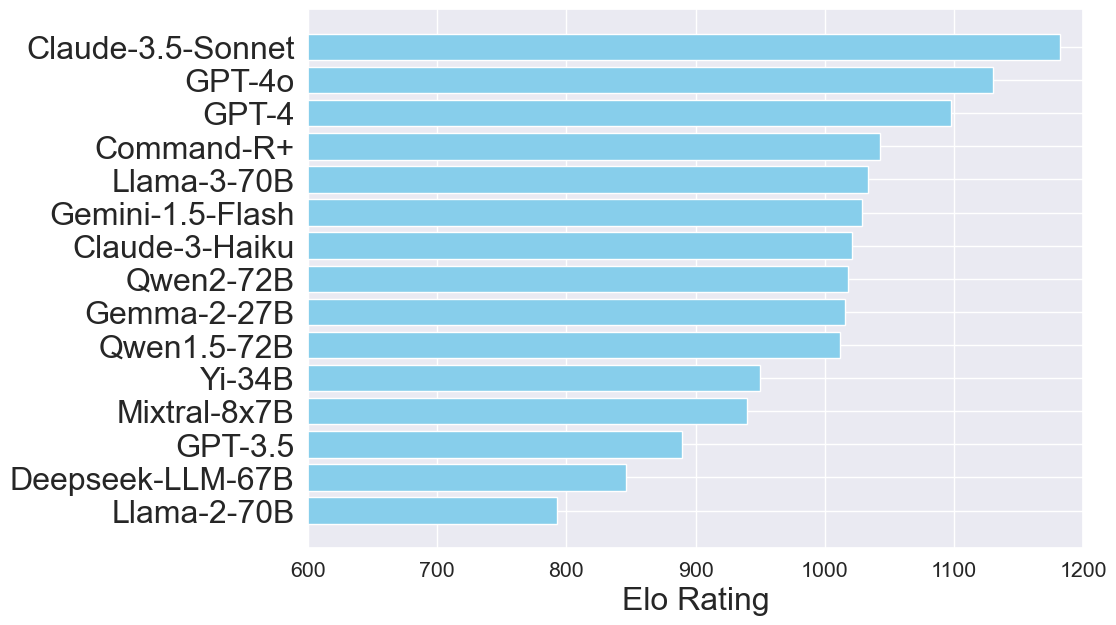

In [19]:
# draw a horizontal bar chart

# main exp
elos = pd.read_csv('../data/main_tour_40/round10_add_gemini-1.5-flash-exp-0827/elo_history.csv')

# chinese exp
# elos = pd.read_csv('../data/main_tour_40_zh/round5_add_gpt-4o-2024-05-13/elo_history_mle.csv')

# sort df columns according to last row value
# Sort DataFrame columns based on the last row values
last_row = elos.iloc[-1, 1:]  # Get the last row, excluding the first column
sorted_columns = last_row.sort_values(ascending=False).index
elos = elos[['Unnamed: 0'] + list(sorted_columns)]  # Keep 'Unnamed: 0' as the first column

models = elos.columns.tolist()[1:][::-1]
names_to_print = {'meta-llama/Llama-2-70b-chat-hf': 'Llama-2-70B', 
                  'deepseek-ai/deepseek-llm-67b-chat': 'Deepseek-LLM-67B', 
                  'gpt-35-turbo-0125': 'GPT-3.5', 
                  'mistralai/Mixtral-8x7B-Instruct-v0.1': 'Mixtral-8x7B', 
                  'zero-one-ai/Yi-34B-Chat': 'Yi-34B', 
                  'Qwen/Qwen2-72B-Instruct': 'Qwen2-72B', 
                  'Qwen/Qwen1.5-72B-Chat': 'Qwen1.5-72B', 
                  'meta-llama/Llama-3-70b-chat-hf': 'Llama-3-70B', 
                  'claude-3-haiku-20240307': 'Claude-3-Haiku', 
                  'command-r-plus': 'Command-R+', 
                  'gpt-4-turbo-2024-04-09': 'GPT-4', 
                  'gpt-4o-2024-05-13': 'GPT-4o', 
                  'claude-3-5-sonnet-20240620': 'Claude-3.5-Sonnet',
                  'google/gemma-2-27b-it': 'Gemma-2-27B',
                  'minimax-abab6.5-chat': 'abab-6.5',
                  'meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo': 'Llama-3.1-70B',
                  'gemini-1.5-flash-exp-0827': 'Gemini-1.5-Flash',
                  'deepseek-chat': 'Deepseek-Chat'}
models = [names_to_print[m] if m in names_to_print else m for m in models]
elos = elos.values[-1][1:][::-1]
# draw a horizontal bar chart
plt.figure(figsize=(10, 7))
plt.barh(models, elos, color='skyblue')
plt.xlabel('Elo Rating', fontsize=23)
# x start from 500
plt.xlim(600, 1200)
# make y ticks smaller
plt.yticks(fontsize=23)
plt.show()

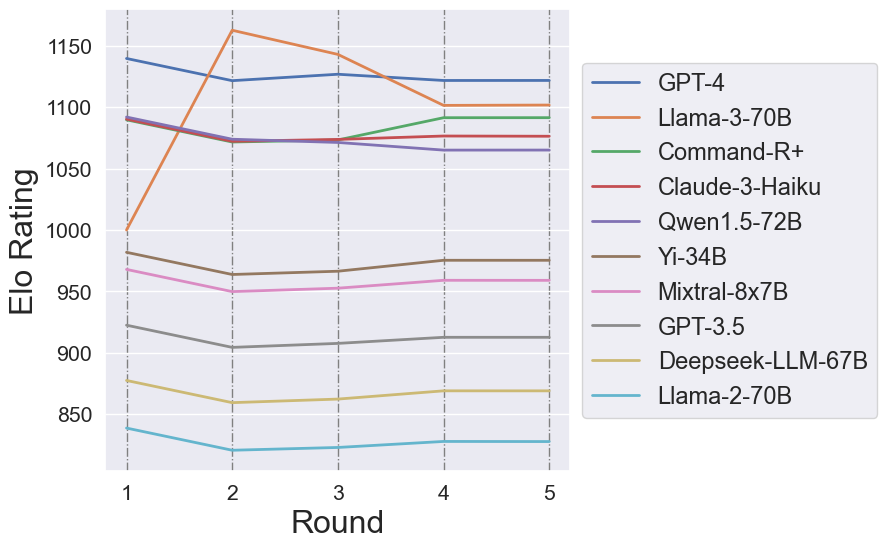

In [20]:
# make a line plot of adding llama3
df = pd.read_csv('../data/main_tour_40/round5_add_meta-llama_Llama-3-70b-chat-hf/elo_history.csv')
fig = plt.figure(figsize = (10, 6))
ax = plt.subplot(111)

models = df.columns.tolist()[1:]
model_names = [names_to_print[m] for m in models]
for i, model in enumerate(models):
    # values is that column
    ax.plot(df[model], label=model_names[i], linewidth = 2)
# make x ticks only integers
ax.set_xticks(range(len(df)))
ax.set_xticklabels(range(1, len(df) + 1))
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.6, box.height])
# set x and y label
ax.set_xlabel('Round', fontsize = 23)
ax.set_ylabel('Elo Rating', fontsize = 23)

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 17)

plt.grid(axis = 'x', color = 'grey', linestyle = 'dashdot', linewidth = 1)
plt.show()

## Analyze correlations between various benchmarks and Chatbot Arena

In [21]:
from scipy import stats

# function to get correlation
def get_correlation(x, y, top_k = 100):
    # skip cases where x or y is not a number (a string) or -1
    bad_indices = []
    for i in range(len(x)):
        # if x[i] or y[i] is a string, check whether it can be converted to a float
        if isinstance(x[i], str):
            try:
                x[i] = float(x[i])
            except:
                bad_indices.append(i)
        if isinstance(y[i], str):
            try:
                y[i] = float(y[i])
            except:
                bad_indices.append(i)
        if isinstance(x[i], (int, float)) and isinstance(y[i], (int, float)) and x[i] > 0 and y[i] > 0:
            continue
        else:
            bad_indices.append(i)
    x = [x[i] for i in range(len(x)) if i not in bad_indices][:top_k]
    y = [y[i] for i in range(len(y)) if i not in bad_indices][:top_k]
    print('sample size: ', len(x))
    if len(x) < 2:
        return None
    res = stats.spearmanr(x, y)
    res_p = stats.pearsonr(x, y)
    print('spearman: ', res.statistic, '\tpearson: ', res_p[0])

In [23]:
# calculate Chatbot Arena ELOs
import pandas as pd
names_arena_to_ours = {'claude-3-5-sonnet-20240620': 'claude-3-5-sonnet-20240620',
                       'gpt-4o-2024-05-13': 'gpt-4o-2024-05-13',
                       'gpt-4-turbo-2024-04-09': 'gpt-4-turbo-2024-04-09',
                       'command-r-plus': 'command-r-plus',
                       'qwen2-72b-instruct': 'Qwen/Qwen2-72B-Instruct',
                       'llama-3-70b-instruct': 'meta-llama/Llama-3-70b-chat-hf',
                       'claude-3-haiku-20240307': 'claude-3-haiku-20240307',
                       'qwen1.5-72b-chat': 'Qwen/Qwen1.5-72B-Chat',
                       'yi-34b-chat': 'zero-one-ai/Yi-34B-Chat',
                       'mixtral-8x7b-instruct-v0.1': 'mistralai/Mixtral-8x7B-Instruct-v0.1',
                       'gpt-3.5-turbo-0125': 'gpt-35-turbo-0125',
                       'deepseek-llm-67b-chat': 'deepseek-ai/deepseek-llm-67b-chat',
                       'llama-2-70b-chat': 'meta-llama/Llama-2-70b-chat-hf',
                       'gemma-2-27b-it': 'google/gemma-2-27b-it',
                       'gemini-1.5-flash-exp-0827': 'gemini-1.5-flash-exp-0827'}
print(f'{len(names_arena_to_ours)} models in ours')

15 models in ours


In [24]:
from collections import defaultdict
def get_elos_from_file(our_models, file):
    elos = pd.read_csv(file)
    results = []
    for model in our_models:
        if model in elos.columns:
            results.append(elos[model].values[-1])
        else:
            results.append('none')
    return results

def get_baselines(baselines, models, column, column_name = 'Model'):
    base = []
    for m in models:
        try:
            base.append(float(baselines.loc[baselines[column_name] == m, column].values[0]))
        except:
            base.append(-1)
    return base

In [25]:
def get_correlations(df, b, top_k = 200, models = None):
    if models is not None:
        # filter down to rows where key is in models
        df = df[df['key'].isin(models)]
    # get correlation
    b1 = df['english_elos'].values
    b2 = df[b].values
    get_correlation(b1, b2, top_k = top_k)

Correlations on the first 9 models

In [27]:
all_baselines = pd.read_csv('../assets/all_baselines.csv')

# arena names
our_models = ['gpt-4-turbo-2024-04-09', 'claude-3-haiku-20240307', 
              'qwen1.5-72b-chat', 'mixtral-8x7b-instruct-v0.1', 
              'yi-34b-chat', 'command-r-plus', 'llama-2-70b-chat',
              'gpt-3.5-turbo-0125', 'deepseek-llm-67b-chat']

baselines = ['mtbench','MMLU', 'alpacaeval',
            'mtbench_hard','openllm_new','GPQA Raw','openllm_old']
for b in baselines:
    print('--------', b, '--------')
    get_correlations(all_baselines, b, top_k = 20, models = our_models)

# get the row where column 'key' is m
arena_elo = [all_baselines[all_baselines['key'] == m]['english_elos'].values[0] for m in our_models]
our_models = [names_arena_to_ours[m] for m in our_models]
our_elo = get_elos_from_file(our_models, '../data/main_tour_40/elo_history.csv')
our_elo_no_debate = get_elos_from_file(our_models, '../data/tour_without_peer_battles/elo_history.csv')
print('--------ours--------')
get_correlation(arena_elo, our_elo)
print('--------ours no debate--------')
get_correlation(arena_elo, our_elo_no_debate)

# no judge discussion elos
no_discussion_judge_results = read_tournament('../data/main_tour_40/', read_added=False)
df = judge_results_to_df(no_discussion_judge_results, judge_debate_rounds=0)
mle_elo = compute_mle_elo(df)
no_discussion_elo = []
for model in our_models:
    no_discussion_elo.append(mle_elo[model])
print('---------ours no discussion--------')
get_correlation(arena_elo, no_discussion_elo)

-------- mtbench --------
sample size:  6
spearman:  0.8285714285714287 	pearson:  0.8182694244322086
-------- MMLU --------
sample size:  6
spearman:  0.6571428571428573 	pearson:  0.5360626784436338
-------- alpacaeval --------
sample size:  7
spearman:  0.8214285714285715 	pearson:  0.9509984106841155
-------- mtbench_hard --------
sample size:  8
spearman:  0.8571428571428572 	pearson:  0.9505230905131559
-------- openllm_new --------
sample size:  3
spearman:  -0.5 	pearson:  -0.9603337505020882
-------- GPQA Raw --------
sample size:  4
spearman:  0.39999999999999997 	pearson:  0.9495093699941721
-------- openllm_old --------
sample size:  4
spearman:  0.0 	pearson:  -0.5217921973139664
--------ours--------
sample size:  9
spearman:  0.9166666666666666 	pearson:  0.8675508461676165
--------ours no debate--------
sample size:  9
spearman:  0.8666666666666667 	pearson:  0.6457427833992142
loaded 640 judge results
---------ours no discussion--------
sample size:  9
spearman:  0.8833

Correlations on the top 15 models

In [28]:
for b in baselines:
    print('--------', b, '--------')
    get_correlations(all_baselines, b, top_k = 15)

all_models = names_arena_to_ours.keys()
# get the row where column 'key' is m
arena_elo = [all_baselines[all_baselines['key'] == m]['english_elos'].values[0] for m in all_models]
all_models = [names_arena_to_ours[m] for m in all_models]
our_elo = get_elos_from_file(all_models, '../data/main_tour_40/round10_add_gemini-1.5-flash-exp-0827/elo_history.csv')
print('--------ours--------')
get_correlation(arena_elo, our_elo)

-------- mtbench --------
sample size:  15
spearman:  0.8873001675315896 	pearson:  0.8118537655079506
-------- MMLU --------
sample size:  15
spearman:  0.4619533223372966 	pearson:  0.482236586113955
-------- alpacaeval --------
sample size:  15
spearman:  0.7631817167208805 	pearson:  0.7425102781919091
-------- mtbench_hard --------
sample size:  15
spearman:  0.4535714285714285 	pearson:  0.43168015438331653
-------- openllm_new --------
sample size:  15
spearman:  0.32499999999999996 	pearson:  0.3807585842266734
-------- GPQA Raw --------
sample size:  15
spearman:  0.6285714285714286 	pearson:  0.587082713873181
-------- openllm_old --------
sample size:  15
spearman:  0.5178571428571428 	pearson:  0.4832110118100654
--------ours--------
sample size:  15
spearman:  0.9214285714285713 	pearson:  0.8809595650948642


In [29]:
# chinese
ours = [1092.539,	1119.510,	1129.325424,	1044.310,	860.183,	982.620,	1076.334,	1006.597,	890.755,	799.160,	998.666]
# dedup
arena = [1302.77,	'na',	1342.75,	'na',	1070.880,	'na',	1241.170,	1210.750,	1230.190,	1177.240, 'na']
ours = [ours[i] for i in range(len(ours)) if arena[i] != 'na']
arena = [arena[i] for i in range(len(arena)) if arena[i] != 'na']
get_correlation(ours, arena)

sample size:  7
spearman:  0.9285714285714288 	pearson:  0.7947992625657474


## Human Study results analysis

In [31]:
human_eval_df = pd.read_csv('../assets/human_eval/human_eval_debates.csv')
human_response_df = pd.read_csv('../assets/human_eval/responses.csv')
human_eval_df['annotator_1'] = human_response_df.iloc[0][1:].to_list()
human_eval_df['annotator_2'] = human_response_df.iloc[1][1:].to_list()
human_eval_df['annotator_discuss'] = human_response_df.iloc[-1][1:].to_list()

In [14]:
# Check Cohen's Kappa Agreement between annotators
rater_1 = human_eval_df['annotator_1'].values
discuss = human_eval_df['annotator_discuss'].values
rater_2 = human_eval_df['annotator_2'].values

non_nan_indices = [i for i, x in enumerate(rater_1) if isinstance(x, str)]
rater_1 = [rater_1[i] for i in non_nan_indices]
rater_2 = [rater_2[i] for i in non_nan_indices]
discuss = [discuss[i] for i in non_nan_indices]
print('Cohen\'s Kappa between two annotators: ', cohen_kappa_score(rater_1, rater_2))

Cohen's Kappa between two annotators:  0.4226804123711341


In [17]:
# Check Cohen's Kappa agreement between annotators and LLM committee
committee = human_eval_df['winner'].values
committee = [committee[i] for i in non_nan_indices]
one_vs_committee = cohen_kappa_score(rater_1, committee)
print('Annotation 1 vs Committee: ', one_vs_committee)
two_vs_committee = cohen_kappa_score(rater_2, committee)
print('Annotation 2 vs Committee: ', two_vs_committee)
print('Average Cohen\'s Kappa between annotators and committee: ', (one_vs_committee + two_vs_committee) / 2)
discuss_vs_committee = cohen_kappa_score(discuss, committee)
print('Discussion vs Committee: ', discuss_vs_committee)

Annotation 1 vs Committee:  0.10197368421052622
Annotation 2 vs Committee:  0.08411214953271018
Average Cohen's Kappa between annotators and committee:  0.0930429168716182
Discussion vs Committee:  0.059701492537313494
